# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


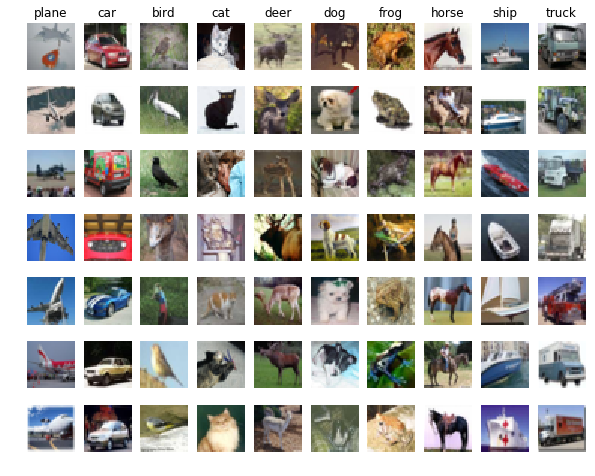

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


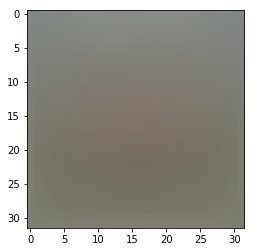

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
np.random.seed(42)
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.797097


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -14.371702 analytic: -14.371702, relative error: 1.237314e-11
numerical: -16.773350 analytic: -16.773350, relative error: 4.750408e-12
numerical: 22.079770 analytic: 22.079770, relative error: 3.533281e-12
numerical: -8.686173 analytic: -8.686173, relative error: 3.968400e-11
numerical: -1.503608 analytic: -1.503608, relative error: 5.989030e-11
numerical: -3.906617 analytic: -3.906617, relative error: 5.841529e-11
numerical: -0.883351 analytic: -0.883351, relative error: 7.740411e-11
numerical: 7.325705 analytic: 7.325705, relative error: 3.423328e-11
numerical: -15.854606 analytic: -15.854606, relative error: 5.142824e-12
numerical: -10.690446 analytic: -10.690446, relative error: 2.533986e-13
numerical: -4.056437 analytic: -4.056437, relative error: 2.409472e-11
numerical: 10.331171 analytic: 10.331171, relative error: 7.010054e-12
numerical: 5.239024 analytic: 5.239024, relative error: 2.303744e-11
numerical: 10.359778 analytic: 10.359778, relative error: 1.345499e-12
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *It is not a reason for concern. It is caused by the fact that the max(0, x) function is not differentiable at the point 0 (the limits from the left and right are not equal).*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.797097e+00 computed in 0.074873s
Vectorized loss: 8.797097e+00 computed in 0.006254s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.091663s
Vectorized loss and gradient: computed in 0.004246s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [67]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=1e3,
                      num_iters=4000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 4000: loss 52.573526
iteration 100 / 4000: loss 39.330176
iteration 200 / 4000: loss 37.566092
iteration 300 / 4000: loss 35.234280
iteration 400 / 4000: loss 32.792367
iteration 500 / 4000: loss 31.951765
iteration 600 / 4000: loss 30.830153
iteration 700 / 4000: loss 29.909003
iteration 800 / 4000: loss 28.022000
iteration 900 / 4000: loss 27.769848
iteration 1000 / 4000: loss 25.821057
iteration 1100 / 4000: loss 25.441422
iteration 1200 / 4000: loss 24.440696
iteration 1300 / 4000: loss 22.143243
iteration 1400 / 4000: loss 22.338130
iteration 1500 / 4000: loss 22.327934
iteration 1600 / 4000: loss 21.522423
iteration 1700 / 4000: loss 20.536303
iteration 1800 / 4000: loss 19.413191
iteration 1900 / 4000: loss 18.223218
iteration 2000 / 4000: loss 18.525870
iteration 2100 / 4000: loss 17.801488
iteration 2200 / 4000: loss 16.729827
iteration 2300 / 4000: loss 16.429824
iteration 2400 / 4000: loss 15.773814
iteration 2500 / 4000: loss 16.094920
iteration 2600 / 4000: l

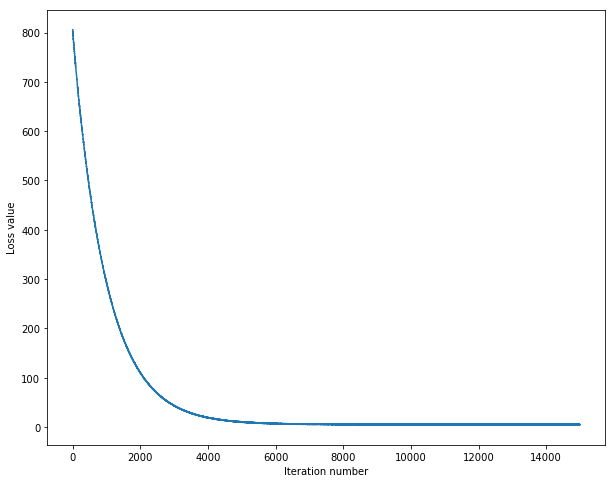

In [25]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [53]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

(49000,)
training accuracy: 0.394408
(1000,)
validation accuracy: 0.394000


In [45]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 1e-6, 5e-5]
regularization_strengths = [1e4, 2.5e4, 5e4, 1e3, 5e3, 1e2]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg_strength, num_iters=1500, verbose=True)
        
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg_strength)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

tic = time.time()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04
iteration 0 / 1500: loss 330.501682
iteration 100 / 1500: loss 213.036451
iteration 200 / 1500: loss 144.273320
iteration 300 / 1500: loss 97.366311
iteration 400 / 1500: loss 66.574759
iteration 500 / 1500: loss 46.174803
iteration 600 / 1500: loss 32.403516
iteration 700 / 1500: loss 23.497072
iteration 800 / 1500: loss 16.705102
iteration 900 / 1500: loss 13.355739
iteration 1000 / 1500: loss 10.505478
iteration 1100 / 1500: loss 8.325751
iteration 1200 / 1500: loss 7.686829
iteration 1300 / 1500: loss 6.495212
iteration 1400 / 1500: loss 6.251166
(49000,)
(1000,)
lr 1.000000e-07 reg 2.500000e+04
iteration 0 / 1500: loss 793.444408
iteration 100 / 1500: loss 290.339003
iteration 200 / 1500: loss 108.750417
iteration 300 / 1500: loss 43.433289
iteration 400 / 1500: loss 19.284627
iteration 500 / 1500: loss 10.529378
iteration 600 / 1500: loss 6.973207
iteration 700 / 1500: loss 5.969788
iteration 800 / 1500: loss 4.919032
iteration 900 / 1500: loss 5.

iteration 400 / 1500: loss 1869694536391113804273204579630096502017819513615775762843348353658076755755730510509949295395499751429942644834846001293480685106270126703902720.000000
iteration 500 / 1500: loss 309045532629284954740256194645374480258454381392061287944828019465467625933087339040971931097968907780158652049048006240961527709678830470495286483293909125225363792472680737800192.000000
iteration 600 / 1500: loss 51082751422310017650135221027483257014950483010344746264541032528712815055805315463868445514552595637270002765323843197269480574964194989588645901537403540501883516572580292937043023194523823353424990405584517857280.000000
iteration 700 / 1500: loss 8443569692378221114852913576544603929395393355842363377372443750866145988300510464361219178653096342754411767321924494602318597191892624022495650707174910376338288389210038465786029375065030417985573694364295268360739246526878925222773056339330465792.000000
iteration 800 / 1500: loss 1395654446266004951708995319950979123886982

/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:89: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:89: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
(49000,)
(1000,)
lr 5.000000e-05 reg 5.000000e+04
iteration 0 / 1500: loss 1545.509545
iteration 100 / 1500: loss 4270055345129270518174127157083473265376215899007826355804753230764609815918684926010016470904379259520810666798280358232064.000000
iteration 200 / 1500: loss 11026349894384411177582040723853324144187903442227760078277240947121510781760183469907896615451259320489049408537082110352967828385193899651370672306037619707576139689087474173591059898615683285106006507406237911731788149067017372479582910808064.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:108: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:104: RuntimeWarning: invalid value encountered in greater
  dmargins = 1.0 * (margins > 0.0).astype(int)
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_classifier.py:71: RuntimeWarning: invalid value encountered in subtract
  self.W = self.W - learning_rate * grad


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
(49000,)
(1000,)
lr 5.000000e-05 reg 1.000000e+03
iteration 0 / 1500: loss 46.686152
iteration 100 / 1500: loss 108.268083
iteration 200 / 1500: loss 116.563290
iteration 300 / 1500: loss 142.093909
iteration 400 / 1500: loss 114.757104
iteration 500 / 1500: loss 157.567139
iteration 600 / 1500: loss 172.925407
iteration 700 / 1500: loss 116.621276
iteration 800 / 1500: loss 174.193706
iteration 900 / 1500: loss 180.785748
iteration 1000 / 1500: loss 135.606414
iteration 1100 / 1500: loss 182.734869
iteration 1200 / 1500: loss 118.645097
iteration 1300 / 1500: loss 139.606515
iteration 1400 / 1500: loss 160.724536
(49000,)
(1000,)
lr 5.000000e-05 reg 5.000000e+03
iteration 0 / 1500: loss 174.171057
iteratio

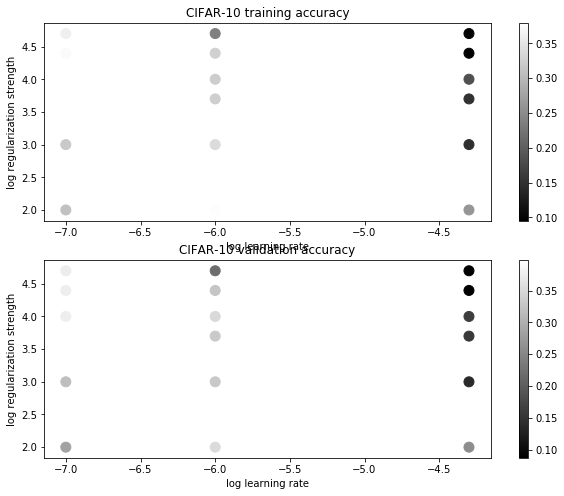

In [40]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [54]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

(1000,)
linear SVM on raw pixels final test set accuracy: 0.358000


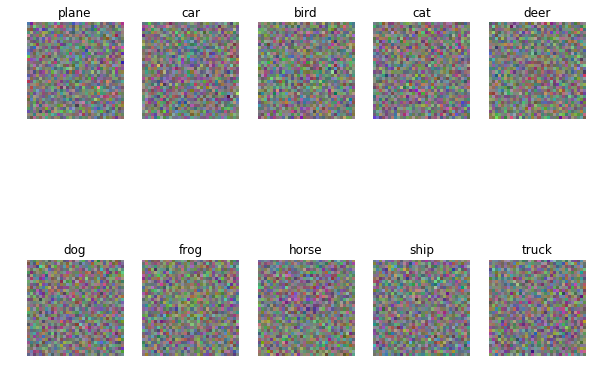

In [68]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *The visualized weights contain a colored countour of the class they belong to. These contours are burred since they were trained to accomodate a whole range of objects from the same class and not a specific one. The regularization strength has effect on the dynamic range of the weights. In some cases this may lead to grainy image after sampling due to aliasing if the range is too large. This happened with small regularization strength during my tests (which means the weights were smaller)*